<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/my_tf_xp/blob/main/custom_loss_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [5]:
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

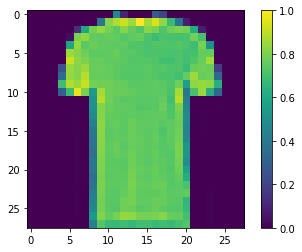

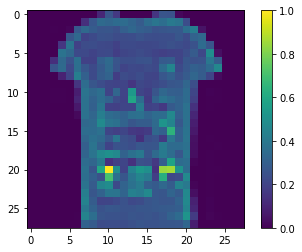

1.0


In [6]:
pair_num = 12
show_image(ts_pairs[pair_num][0])
show_image(ts_pairs[pair_num][1])
print(ts_y[pair_num])

In [7]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation= tf.keras.activations.relu),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(128, activation= tf.keras.activations.relu),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(128, activation= tf.keras.activations.relu),
])

In [8]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.keras.backend.sum(tf.keras.backend.square(x - y), axis=1, keepdims=True)
    return tf.keras.backend.sqrt(tf.keras.backend.maximum(sum_square, tf.keras.backend.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [9]:
input_a = tf.keras.layers.Input(shape=(28,28,), name="left_input")
vect_output_a = base_model(input_a)

In [10]:
vect_output_a

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'sequential')>

In [11]:
input_b = tf.keras.layers.Input(shape=(28,28,), name="right_input")
vect_output_b = base_model(input_b)

In [12]:
output = tf.keras.layers.Lambda(
    euclidean_distance, 
    name="output_layer", 
    output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

In [13]:
model = tf.keras.models.Model([input_a, input_b], output)

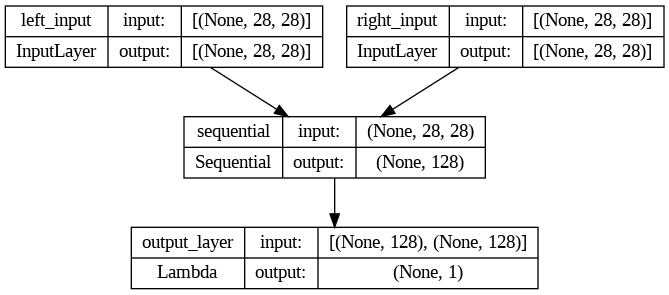

In [14]:
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True, to_file='outer-model.png'
    )

In [15]:
# def contrastive_loss_with_margin(margin):
#     def contrastive_loss(y_true, y_pred):
#         square_pred = tf.keras.backend.square(y_pred)
#         margin_square = tf.keras.backend.square(tf.keras.backend.maximum(margin - y_pred, 0))
#         return (y_true * square_pred + (1 - y_true) * margin_square)
#     return contrastive_loss

In [18]:
class contrastive_loss_with_margin(tf.keras.losses.Loss):
    margin = 1
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
    def call(self, y_true, y_pred):
        square_pred = tf.keras.backend.square(y_pred)
        margin_square = tf.keras.backend.square(
            tf.keras.backend.maximum(self.margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)

In [19]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer="adam")

In [20]:
history = model.fit(
    [tr_pairs[:,0], tr_pairs[:,1]], tr_y, 
    epochs=20, 
    batch_size=128, 
    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y)
    )

Epoch 1/20
938/938 [==============================] - 10s 5ms/step - loss: 0.1176 - val_loss: 0.0866
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0844 - val_loss: 0.0798
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0759 - val_loss: 0.0730
Epoch 4/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0713 - val_loss: 0.0709
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0684 - val_loss: 0.0680
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0658 - val_loss: 0.0671
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0635 - val_loss: 0.0686
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0617 - val_loss: 0.0666
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0604 - val_loss: 0.0644
Epoch 10/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0591 - val_loss: 0.066

625/625 [==============================] - 1s 2ms/step
Loss = 0.06364325433969498, Train Accuracy = 0.9399816636106018 Test Accuracy = 0.912962962962963


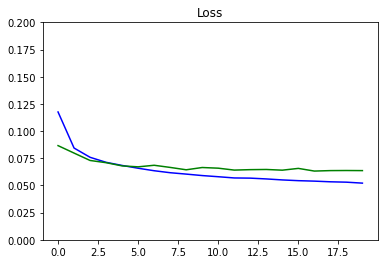

In [21]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

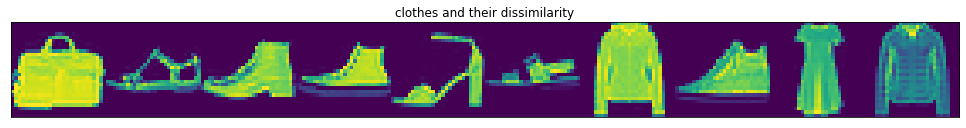

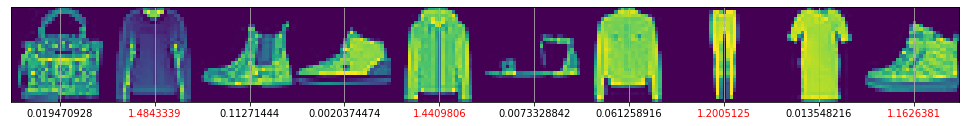

In [23]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)